---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

## Introduction and Motivation

While unsupervised learning helps uncover patterns in food waste data, supervised learning can provide actionable predictions that directly inform decision-making processes. Supervised learning techniques, such as classification and regression, are essential for predicting outcomes like the surplus dollar value of wasted food or classifying food donations based on nutritional composition. By training models on labeled data, we can predict which food items are most likely to be wasted, which can help inform better resource allocation and waste reduction strategies.

In this project, supervised learning will be used to predict the economic impact of food waste by estimating the dollar surplus associated with surplus food. This involves building regression models that take into account factors such as the nutritional content, environmental footprint, and food category to forecast economic losses. Additionally, classification models will be employed to identify which food donations are most suitable for redistribution based on their nutritional value and waste characteristics. These insights will guide the development of policies and practices to reduce food waste and its associated environmental and economic costs. By combining supervised learning with unsupervised insights, this project aims to create a comprehensive framework for mitigating food waste through data-driven strategies.

## Model Selection and Code

Here, we have built and evaluated three distinct types of machine learning models to address different aspects of food waste prediction and resource optimization. These models—multi-class classification, binary classification, and regression—each tackle unique challenges and offer insights into different dimensions of food waste management.

1. Multi-Class Classification:

The first model is a multi-class classification task, where the goal is to predict the primary disposal method for different food items based on their physical characteristics and nutritional content. In this case, the target variable is the disposal method, which can take on multiple possible values (e.g., composting, recycling, or landfill). By leveraging features such as water footprint, nutritional composition (e.g., calories, protein, fat), and food categories, we aim to predict the most likely disposal method for each food item. This model is particularly useful in scenarios where the disposal method needs to be optimized based on the type of food waste, offering insights into how different food characteristics influence disposal choices.

2. Binary Classification:

The second model is a binary classification task, which is designed to predict whether a given food item is fit for human consumption or not. This model uses various nutritional and environmental features as inputs, including surplus quantities, water footprint, and food characteristics. The target variable is binary: a food item is either classified as fit for consumption (0) or not fit for consumption (1). This binary classification task is valuable for food waste management systems where the goal is to separate consumable food from inedible or waste-bound food. The model’s output can guide decisions about redistribution, donation, or disposal, thus helping reduce food wastage by ensuring that edible food is appropriately utilized.

3. Regression:

The third model is a regression task, which predicts the surplus value of food in US dollars based on various physical and nutritional features. Unlike classification, regression involves predicting a continuous variable—in this case, the monetary value of surplus food. The model utilizes features like food categories, nutritional content, and water footprint to estimate the financial surplus. This type of model is instrumental in helping organizations quantify the economic impact of food waste and identify opportunities for recovering value from surplus food. By accurately predicting the surplus value, the model can inform decisions around reselling, donating, or optimizing the food supply chain for maximum economic benefit.

### Model Rationale

The choice of models—K-Nearest Neighbors (KNN), Random Forest, and Support Vector Machines (SVM)—was guided by their complementary strengths.

•	KNN: Selected for its simplicity and effectiveness in handling multiclass problems with non-linear decision boundaries.

•	Random Forest: Chosen for its robust performance across diverse datasets, ability to handle high-dimensional data, and built-in feature importance evaluation.

•	SVM: Included for its strength in finding optimal hyperplanes in high-dimensional spaces and its kernel flexibility for complex decision boundaries.

### Overview of Algorithms

•	KNN: Classifies samples by majority voting among k nearest neighbors in the feature space, using distance metrics like Manhattan or Euclidean.

•	Random Forest: Constructs multiple decision trees during training, averaging their outputs for classification to reduce overfitting and variance.

•	SVM: Uses a hyperplane to separate classes with maximum margin and can apply non-linear kernels such as RBF for complex classification tasks.

### Split Methods

The dataset was divided into training and testing subsets using a train-test split, ensuring that the model’s performance generalizes to unseen data. Additionally, cross-validation (GridSearchCV) was used during hyperparameter tuning to assess the model’s stability and avoid overfitting.

### Dataset Proportions

The dataset was split into 80% training data and 20% testing data to ensure adequate data for both model training and evaluation.

### Preprocessing Techniques

Normalization

A StandardScaler was applied to normalize the feature variables, ensuring that all features have zero mean and unit variance. This step was particularly critical for algorithms like SVM and KNN, which are sensitive to the scale of input data.

Balancing the Dataset

Class imbalances were addressed using SMOTE (Synthetic Minority Oversampling Technique) combined with ENN (Edited Nearest Neighbors) via SMOTEENN. This method oversamples the minority classes and removes noisy samples near class boundaries, ensuring balanced class representation in the training data.




In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class SupervisedLearning:
    def __init__(self, data):
        self.data = data
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

    def prepare_data(self, input_features, target_feature, test_size=0.2, val_size=0.2, balance_data=True, cat_target = True):
        # Drop rows with missing target or feature values
        self.data = self.data.dropna(subset=input_features + [target_feature])
    
        # Extract features and target
        X = self.data[input_features]
        y = self.data[target_feature]

    
        if cat_target:
            # Further split training+validation into training and validation sets
            # Split into training+validation and test sets
            X_train_val, X_test, y_train_val, y_test = train_test_split(
                X, y, test_size=test_size, stratify=y, random_state=42
            )

            X_train, X_val, y_train, y_val = train_test_split(
                X_train_val, y_train_val, test_size=val_size / (1 - test_size), stratify=y_train_val, random_state=42
            )
        else:
            # Split into training+validation and test sets
            X_train_val, X_test, y_train_val, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42
            )
            X_train, X_val, y_train, y_val = train_test_split(
                X_train_val, y_train_val, test_size=val_size / (1 - test_size), random_state=42
            )
    
        # Balance the data using SMOTEENN if specified
        if balance_data:
            class_counts = y_train.value_counts()
            min_class_samples = class_counts.min()
            k_neighbors = min(5, min_class_samples - 1)  # Ensure k_neighbors < min_class_samples
        
            if k_neighbors < 1:
                print("Skipping SMOTEENN as one or more classes have fewer than 2 samples.")
            else:
                smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
                smoteenn = SMOTEENN(random_state=42, smote=smote)
                X_train, y_train = smoteenn.fit_resample(X_train, y_train)
    
        # Store the splits
        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

    def multiclass_classification(self, input_features, target_feature, model_type="knn", use_scaling=True, **model_params):
        # Standardize the features if required
        if use_scaling:
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)
            self.X_val = scaler.transform(self.X_val)

        # Choose model and perform tuning (if applicable)
        if model_type == "knn":
            param_grid = {
                'n_neighbors': [3, 5, 7, 10],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
            self.grid_search_model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)

        elif model_type == "random_forest":
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [1,2,3, 5, 7, 10],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'max_features': ['sqrt', 'log2', None]
            }
            self.grid_search_model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, n_jobs=-1)

        elif model_type == "svm":
            param_grid = {
                'C': [0.1, 0.1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            }
            self.grid_search_model = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, n_jobs=-1)

        else:
            raise ValueError("Unsupported model_type. Use 'knn', 'random_forest', or 'svm'.")

        # Fit the GridSearchCV model
        self.grid_search_model.fit(self.X_train, self.y_train)

        # Retrieve best estimator and parameters
        self.model = self.grid_search_model.best_estimator_
        print("Best Parameters:", self.grid_search_model.best_params_)
        print("Best Cross-Validation Score:", self.grid_search_model.best_score_)

        # Predictions
        y_pred = self.model.predict(self.X_test)

        # Evaluation
        print("Classification Report:\n", classification_report(self.y_test, y_pred))
        cm = confusion_matrix(self.y_test, y_pred)

        # Plotting Confusion Matrix
        fig, ax = plt.subplots(figsize=(12, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.model.classes_)
        disp.plot(cmap='viridis', values_format='d', ax=ax)
        plt.title("Confusion Matrix")
        plt.show()

        # Feature importance plot (for models that support it)
        if model_type == "random_forest":
            feature_importances = self.model.feature_importances_
            sns.barplot(x=feature_importances, y=input_features)
            plt.title("Feature Importances")
            plt.show()

        # Returning model and metrics for further analysis
        return {
            "model": self.model,
            "classification_report": classification_report(self.y_test, y_pred, output_dict=True),
            "confusion_matrix": cm
        }
    def one_hot_encode(self, column):
        """
        One-hot encode a specified categorical column in the dataset.
        
        Parameters:
            column (str): The name of the column to be one-hot encoded.
        """
        if column not in self.data.columns:
            raise ValueError(f"Column '{column}' not found in the dataset.")
        
        # Perform one-hot encoding
        encoded_columns = pd.get_dummies(self.data[column], prefix=column)
        
        # Drop the original column and concatenate the new one-hot encoded columns
        self.data = pd.concat([self.data.drop(columns=[column]), encoded_columns], axis=1)
        print(f"One-hot encoded column '{column}' and updated the dataset.")
        
    def regression(self, input_features, target_feature, model_type="random_forest", use_scaling=True, **model_params):
        # Standardize the features if required
        if use_scaling:
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)
            self.X_val = scaler.transform(self.X_val)

        # Choose model and define parameter grid
        if model_type == "random_forest":
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'max_features': ['sqrt', 'log2', None]
            }
            self.grid_search_model = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1)

        elif model_type == "linear_regression":
            self.grid_search_model = LinearRegression()
        
        else:
            raise ValueError("Unsupported model_type. Use 'random_forest' or 'linear_regression'.")

        # Fit the model
        self.grid_search_model.fit(self.X_train, self.y_train)

        # If GridSearchCV was used, get the best estimator
        if model_type == "random_forest":
            self.model = self.grid_search_model.best_estimator_
            print("Best Parameters:", self.grid_search_model.best_params_)
            print("Best Cross-Validation Score:", self.grid_search_model.best_score_)
        else:
            self.model = self.grid_search_model
        
        # Predictions
        y_pred = self.model.predict(self.X_test)

        # Evaluation Metrics
        mse = mean_squared_error(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)

        print("Mean Squared Error (MSE):", mse)
        print("Mean Absolute Error (MAE):", mae)
        print("R-squared (R2):", r2)

        # Returning model and metrics for further analysis
        return {
            "model": self.model,
            "mse": mse,
            "mae": mae,
            "r2": r2
        }
    
    def binary_classification(self, input_features, target_feature, model_type="random_forest", use_scaling=True, **model_params):
        # Standardize the features if required
        if use_scaling:
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)
            self.X_val = scaler.transform(self.X_val)

        # Choose model and perform tuning (if applicable)
        if model_type == "knn":
            param_grid = {
                'n_neighbors': [3, 5, 7, 10],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
            self.grid_search_model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)

        elif model_type == "random_forest":
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7, 10,15, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'max_features': ['sqrt', 'log2', None]
                }
            self.grid_search_model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, n_jobs=-1)

        elif model_type == "svm":
            param_grid = {
                'C': [0.1, 0.5, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            }
            self.grid_search_model = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, n_jobs=-1)

        else:
            raise ValueError("Unsupported model_type. Use 'knn', 'random_forest', or 'svm'.")

        # Fit the GridSearchCV model
        self.grid_search_model.fit(self.X_train, self.y_train)

        # Retrieve best estimator and parameters
        self.model = self.grid_search_model.best_estimator_
        print("Best Parameters:", self.grid_search_model.best_params_)
        print("Best Cross-Validation Score:", self.grid_search_model.best_score_)

        # Predictions
        y_pred = self.model.predict(self.X_test)

        # Evaluation
        print("Classification Report:\n", classification_report(self.y_test, y_pred))
        cm = confusion_matrix(self.y_test, y_pred)

        # Plotting Confusion Matrix
        fig, ax = plt.subplots(figsize=(12, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.model.classes_)
        disp.plot(cmap='viridis', values_format='d', ax=ax)
        plt.title("Confusion Matrix")
        plt.show()

        # Returning model and metrics for further analysis
        return {
            "model": self.model,
            "classification_report": classification_report(self.y_test, y_pred, output_dict=True),
            "confusion_matrix": cm
        }

In [4]:
data = pd.read_csv('../../data/processed-data/food_merged.csv')

category_columns = [
    'tons_donations', 'tons_industrial_uses', 'tons_animal_feed',
    'tons_anaerobic_digestion', 'tons_composting', 'tons_not_harvested',
    'tons_incineration', 'tons_land_application', 'tons_landfill',
    'tons_sewer', 'tons_dumping'
]

data['total'] = data[category_columns].sum(axis=1)

# Calculate the percentage of total for each column
percentage_df = data[category_columns].div(data['total'], axis=0)

# Find the column with the maximum percentage for each row
data['disposal_method'] = percentage_df.idxmax(axis=1)
data['disposal_method'] = data['disposal_method'].str.replace('tons_', '', regex=False)

# Drop the total column if no longer needed
data.drop(columns=['total'], inplace=True)

data['donation_bin'] = np.where(data['tons_donations'] > 0, 1, 0)
print(data.shape)

(7084, 42)


/var/folders/sj/4yswlk7n08x8jfcfnyw2vkqw0000gn/T/ipykernel_89931/718609560.py:16: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  data['disposal_method'] = percentage_df.idxmax(axis=1)


## Multi Class Classification

This implementation aims to predict the disposal method—the primary way a specific type of food waste is handled—using machine learning models in a multiclass classification framework. The target variable is disposal_method, which includes categories such as landfill, composting, animal_feed, not_harvested, and sewer.

The feature variables used for prediction are:

•	Physical Waste Characteristics: tons_surplus, tons_supply, tons_waste, tons_inedible_parts

•	Environmental Impact Factor: gallons_water_footprint

•	Nutritional Composition: serving_size, calories, protein, fat, carbs, fiber, calcium, iron, sodium

By leveraging these features, the project seeks to identify patterns in waste management, enabling better decision-making for sustainability and resource optimization across the food supply chain.


--- KNN Model Testing ---
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Score: 0.9859447031830759
Classification Report:
                precision    recall  f1-score   support

  animal_feed       1.00      1.00      1.00         3
   composting       0.79      0.95      0.86       123
     landfill       0.99      0.92      0.95       961
not_harvested       0.80      0.97      0.88       137
        sewer       0.75      1.00      0.86        39

     accuracy                           0.93      1263
    macro avg       0.87      0.97      0.91      1263
 weighted avg       0.94      0.93      0.93      1263



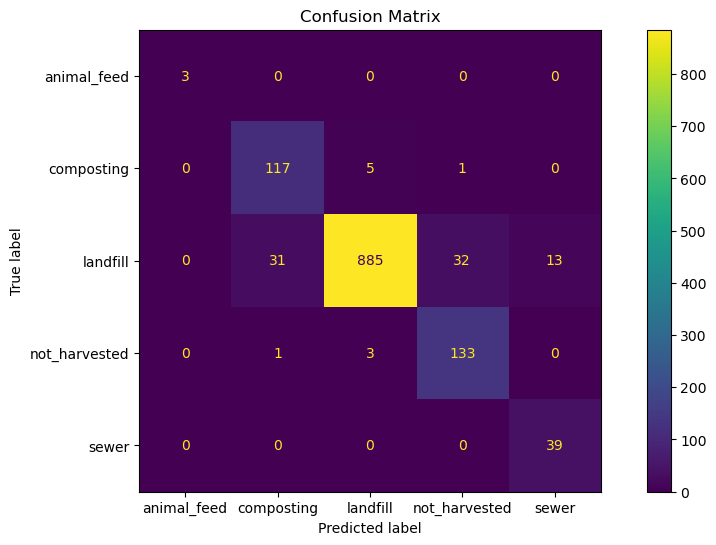

Trained KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

--- Random Forest Model Testing ---
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.9934739579764355
Classification Report:
                precision    recall  f1-score   support

  animal_feed       1.00      1.00      1.00         3
   composting       0.83      0.94      0.88       123
     landfill       0.99      0.92      0.95       961
not_harvested       0.72      0.96      0.82       137
        sewer       0.87      1.00      0.93        39

     accuracy                           0.93      1263
    macro avg       0.88      0.97      0.92      1263
 weighted avg       0.94      0.93      0.93      1263



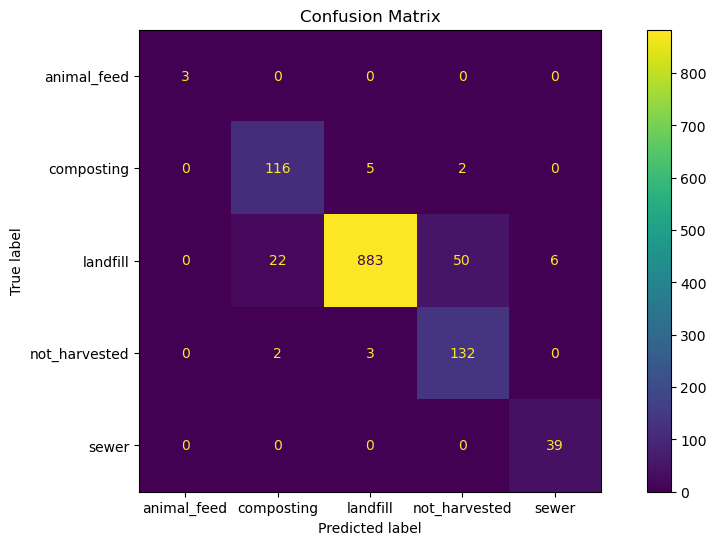

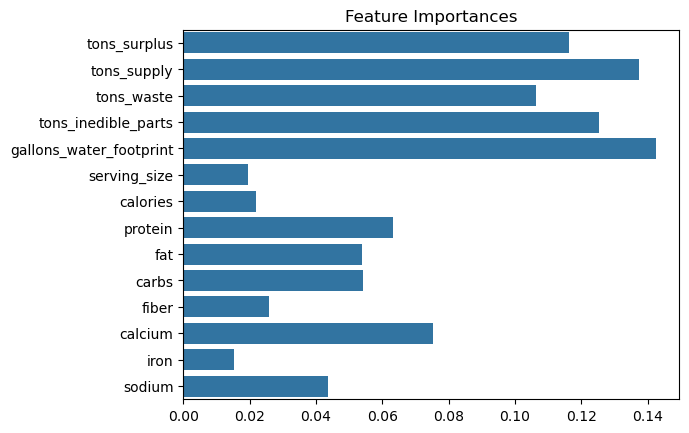

Trained Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

--- SVM Model Testing ---
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9444031722852726
Classification Report:
                precision    recall  f1-score   support

  animal_feed       0.50      1.00      0.67         3
   composting       0.41      0.97      0.58       123
     landfill       0.99      0.76      0.86       961
not_harvested       0.55      0.72      0.62       137
        sewer       0.72      1.00      0.84        39

     accuracy                           0.78      1263
    macr

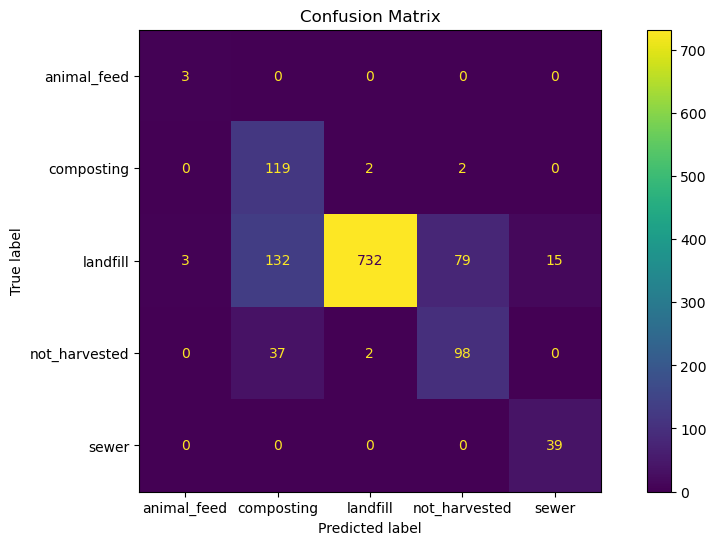

Trained SVM Model Parameters: {'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [10]:
feature_columns = [
    'tons_surplus', 'tons_supply', 'tons_waste', 'tons_inedible_parts',
    'gallons_water_footprint', 'serving_size', 'calories', 'protein', 'fat', 'carbs',
    'fiber', 'calcium', 'iron', 'sodium'
]
target_column = 'disposal_method'  
learner = SupervisedLearning(data)
learner.prepare_data(feature_columns, target_column)

print("\n--- KNN Model Testing ---")
knn_result = learner.multiclass_classification(
    input_features=feature_columns,
    target_feature=target_column,
    model_type="knn"
)

print("Trained KNN Model Parameters:", knn_result["model"].get_params())

print("\n--- Random Forest Model Testing ---")

random_forest_result = learner.multiclass_classification(
    input_features=feature_columns,
    target_feature=target_column,
    model_type="random_forest"
)

# Best Parameters and Model Output
print("Trained Model Parameters:", random_forest_result["model"].get_params())
# SVM Testing
print("\n--- SVM Model Testing ---")
svm_result = learner.multiclass_classification(
    input_features=feature_columns,
    target_feature=target_column,
    model_type="svm"
)

print("Trained SVM Model Parameters:", svm_result["model"].get_params())

### Model Evaluation Metrics

#### Multiclass Classification Metrics

•	Accuracy: Measures the percentage of correctly classified samples across all classes.

•	Precision, Recall, F1-Score: Evaluates the model’s performance for each class, balancing false positives and false negatives.

•	Confusion Matrix: Used to visualize the distribution of predictions across classes.

•	Cross-Validation Score: Captures model consistency by evaluating performance across multiple data splits.

### Results

1.	KNN:

    •	Best Cross-Validation Score: 0.986
	
    •	Classification Report: Demonstrated strong performance, particularly for large classes like landfill, while showing some variability for minority classes such as animal_feed.

2.	Random Forest:

    •	Best Cross-Validation Score: 0.993

    •	Classification Report: Delivered excellent performance with well-balanced precision and recall across all classes, reflecting its robust nature in handling imbalanced datasets.

3.	SVM:

    •	Best Cross-Validation Score: 0.944

    •	Classification Report: Achieved reasonable performance but struggled with smaller classes like animal_feed, likely due to limited data and the complexity of separating the classes.

### Implications

The results of this project provide valuable insights into food waste management practices. Accurate classification of disposal methods based on physical, environmental, and nutritional factors can:

•	Enable targeted policy interventions for waste reduction.

•	Inform stakeholders about the environmental impact of different disposal methods.

•	Support resource allocation for improving sustainable waste management practices.

Future efforts could include expanding the dataset, incorporating additional features (e.g., geographic data), and exploring advanced ensemble techniques for even greater predictive accuracy.

## Binary Classification

Here, we aim to predict whether food will be donated or not based on its nutritional and physical attributes. The task is framed as a binary classification problem, where the target variable is donation_bin, which indicates if a food item is suitable for donation (1) or not (0).

The input features used for prediction include various food-related characteristics, such as:

•	Environmental Impact Factor: gallons_water_footprint

•	Nutritional Composition: serving_size, calories, protein, fat, carbs, fiber, calcium, iron, sodium

These features are intended to capture the physical and nutritional profile of food that may influence whether it’s fit for donation. The target variable is donation_bin, which represents whether the food item is suitable for donation


--- KNN Model Testing ---
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Cross-Validation Score: 0.9394957867108717
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       609
           1       0.87      0.90      0.88       688

    accuracy                           0.88      1297
   macro avg       0.88      0.87      0.88      1297
weighted avg       0.88      0.88      0.88      1297



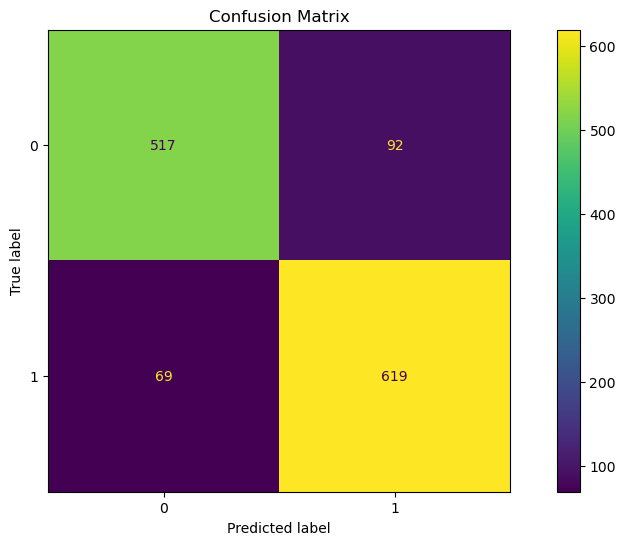

{'model': KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance'), 'classification_report': {'0': {'precision': 0.8822525597269625, 'recall': 0.8489326765188834, 'f1-score': 0.8652719665271966, 'support': 609.0}, '1': {'precision': 0.870604781997187, 'recall': 0.8997093023255814, 'f1-score': 0.8849177984274482, 'support': 688.0}, 'accuracy': 0.8758673862760216, 'macro avg': {'precision': 0.8764286708620748, 'recall': 0.8743209894222324, 'f1-score': 0.8750948824773224, 'support': 1297.0}, 'weighted avg': {'precision': 0.876073939003689, 'recall': 0.8758673862760216, 'f1-score': 0.8756931942429816, 'support': 1297.0}}, 'confusion_matrix': array([[517,  92],
       [ 69, 619]])}

--- Random Forest Model Testing ---
Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Score: 0.965279734769996
Classification Report:
               precision    recall  f1-score   support

     

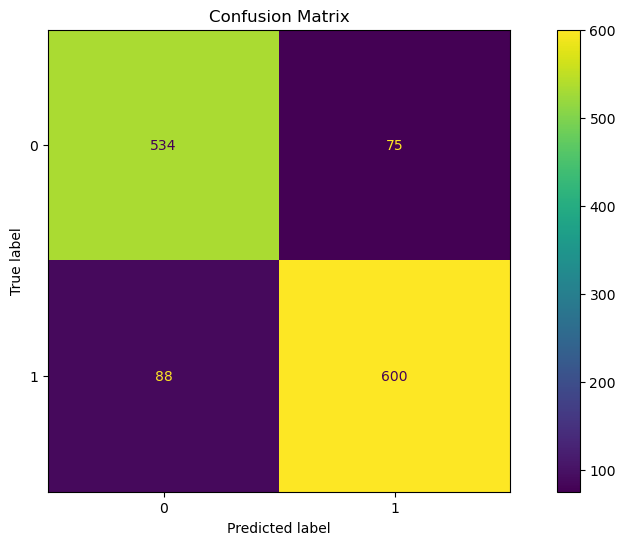

{'model': RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=300,
                       random_state=42), 'classification_report': {'0': {'precision': 0.8585209003215434, 'recall': 0.8768472906403941, 'f1-score': 0.867587327376117, 'support': 609.0}, '1': {'precision': 0.8888888888888888, 'recall': 0.872093023255814, 'f1-score': 0.880410858400587, 'support': 688.0}, 'accuracy': 0.874325366229761, 'macro avg': {'precision': 0.8737048946052162, 'recall': 0.874470156948104, 'f1-score': 0.873999092888352, 'support': 1297.0}, 'weighted avg': {'precision': 0.8746297485361414, 'recall': 0.874325366229761, 'f1-score': 0.8743896321909476, 'support': 1297.0}}, 'confusion_matrix': array([[534,  75],
       [ 88, 600]])}

--- SVM Model Testing ---
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.7290716949854953
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.43      0.

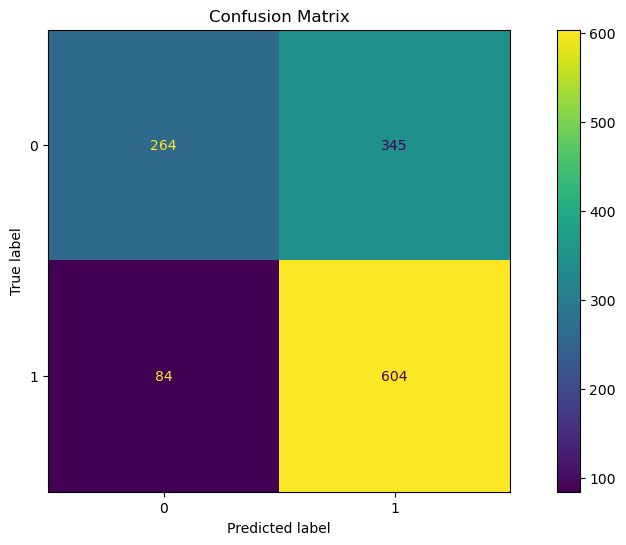

{'model': SVC(C=10, class_weight='balanced', gamma='auto', random_state=42), 'classification_report': {'0': {'precision': 0.7586206896551724, 'recall': 0.43349753694581283, 'f1-score': 0.5517241379310345, 'support': 609.0}, '1': {'precision': 0.6364594309799789, 'recall': 0.877906976744186, 'f1-score': 0.7379352474037875, 'support': 688.0}, 'accuracy': 0.669236700077101, 'macro avg': {'precision': 0.6975400603175756, 'recall': 0.6557022568449995, 'f1-score': 0.644829692667411, 'support': 1297.0}, 'weighted avg': {'precision': 0.6938196518999425, 'recall': 0.669236700077101, 'f1-score': 0.6505007326243684, 'support': 1297.0}}, 'confusion_matrix': array([[264, 345],
       [ 84, 604]])}


In [5]:
input_features = [
    'gallons_water_footprint',
    'serving_size',
    'protein',
    'fat',
    'carbs',
    'calories',
    'fiber',
    'calcium',
    'iron',
    'sodium',
]

# Target feature (donation_bin)
target_feature = 'donation_bin'

sl = SupervisedLearning(data)

# Prepare the data for training (this will split the data and apply SMOTE if required)
sl.prepare_data(input_features, target_feature)
print("\n--- KNN Model Testing ---")

# Perform binary classification with random forest (you can choose other models as well)
results_knn = sl.binary_classification(input_features, target_feature, model_type="knn", use_scaling=True)

# Output the results
print(results_knn)

print("\n--- Random Forest Model Testing ---")

results_random_forest = sl.binary_classification(input_features, target_feature, model_type="random_forest", use_scaling=True)

# Output the results
print(results_random_forest)

print("\n--- SVM Model Testing ---")

results_svm = sl.binary_classification(input_features, target_feature, model_type="svm", use_scaling=True)

# Output the results
print(results_svm)



### Model Evaluation Metrics

#### Binary Classification Metrics

•	Accuracy: Measures the percentage of correctly classified samples across all classes.

•	Precision, Recall, F1-Score: Evaluates the model’s performance for each class, balancing false positives and false negatives.

•	Confusion Matrix: Used to visualize the distribution of predictions across classes.

•	Cross-Validation Score: Captures model consistency by evaluating performance across multiple data splits.

### Results

1.	KNN:

    •	Best Cross-Validation Score: 0.939
	

2.	Random Forest:

    •	Best Cross-Validation Score: 0.965


3.	SVM:

    •	Best Cross-Validation Score: 0.729

    

### Implications

•	Model Performance: The Random Forest and KNN models performed well, with accuracy scores of approximately 87% and 88%, respectively. These models also showed a good balance of precision and recall, especially for class 1 (donation), where recall was higher than precision, suggesting that the models are better at identifying suitable donation items.

•	Model Comparison: The SVM model, despite having a high recall for class 1, struggled with precision and overall accuracy. This suggests that SVM might be less suited for this particular classification task, especially if false positives are a significant concern.

•	Practical Application: A high-performing model can help in identifying food items that are eligible for donation, which can be leveraged in food recovery programs. The models can help reduce food waste by accurately predicting which food is fit for donation based on its nutritional and physical properties.

## Linear Reggression

This analysis involves testing two regression models (Random Forest and Linear Regression) to predict the us_dollars_surplus of food items. The dataset includes features such as nutritional content and water footprint, along with one-hot encoded values for the food_category column. The goal is to predict the surplus value (in dollars) based on these characteristics, and the models’ performance is assessed using common regression metrics.

The input features used for prediction include various food-related characteristics, such as:

•	Environmental Impact Factor: gallons_water_footprint

•	Nutritional Composition: serving_size, calories, protein, fat, carbs, fiber, calcium, iron, sodium

•	One Hot Encoded Food Category: food_category


### Model Evaluation Metrics:

The evaluation metrics provide a way to assess how well each model performs on the regression task. The primary metrics used here are:

•	Mean Squared Error (MSE): This metric quantifies the average squared difference between the actual and predicted values. A lower MSE indicates a better fit of the model to the data.

•	Mean Absolute Error (MAE): This metric gives the average of the absolute differences between predicted and actual values. Like MSE, a lower MAE is preferred, but it is less sensitive to outliers compared to MSE.

•	R-squared (R²): This metric indicates the proportion of the variance in the target variable that is predictable from the independent variables. An R² value closer to 1 means the model explains most of the variance in the data, while a value closer to 0 suggests a poor fit.

In [6]:
# Instantiate the class
sl = SupervisedLearning(data)

# One-hot encode the 'food_category' column
sl.one_hot_encode('food_category')

# Define input and target features
input_features = [
    'gallons_water_footprint', 'protein', 'fat', 'carbs', 'calories', 'fiber',
    'calcium', 'iron', 'sodium'
] + [col for col in sl.data.columns if col.startswith('food_category_')]  
target_feature = 'us_dollars_surplus'

# Prepare the data
sl.prepare_data(input_features, target_feature, cat_target = False)

# Perform regression
print("\n--- Random Forest Model Testing ---")

results_rf = sl.regression(input_features, target_feature, model_type="random_forest", use_scaling=True)
print(results_rf)

# Perform regression
print("\n--- Linear Reggression Model Testing ---")

results_lr = sl.regression(input_features, target_feature, model_type="linear_regression", use_scaling=True)
print(results_lr)

One-hot encoded column 'food_category' and updated the dataset.
Skipping SMOTEENN as one or more classes have fewer than 2 samples.

--- Random Forest Model Testing ---


/Users/shanaywadhwani/Desktop/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.9692753382410217
Mean Squared Error (MSE): 1.0930396794092634e+16
Mean Absolute Error (MAE): 54092284.88337758
R-squared (R2): 0.9679093204991429
{'model': RandomForestRegressor(max_depth=20, max_features='sqrt', random_state=42), 'mse': 1.0930396794092634e+16, 'mae': 54092284.88337758, 'r2': 0.9679093204991429}

--- Linear Reggression Model Testing ---
Mean Squared Error (MSE): 8.536678751781533e+16
Mean Absolute Error (MAE): 156127623.3713102
R-squared (R2): 0.7493706523323531
{'model': LinearRegression(), 'mse': 8.536678751781533e+16, 'mae': 156127623.3713102, 'r2': 0.7493706523323531}


### Results

**Random Forest Model**:

The Random Forest model’s high R² value (96.79%) and relatively low error metrics (MSE and MAE) suggest that it is well-suited for predicting us_dollars_surplus in this context. The model’s ability to capture complex, non-linear relationships between the input features (such as nutritional content, water footprint, and food category) makes it a powerful tool for this regression task. The strong performance of the Random Forest model implies that the factors influencing food surplus are likely complex and interdependent, and a tree-based approach that considers interactions between variables is optimal.

Implications for Decision-Making:

•	This model can be trusted to provide relatively accurate estimates of food surplus, which is crucial for resource management, sustainability efforts, and forecasting food waste reduction strategies.

•	The high R² also suggests that predictive decisions (e.g., optimizing food donations based on surplus values) can be made with a high degree of confidence.

**Linear Regression Model**:

The Linear Regression model, with an R² of 74.94%, performs substantially worse than Random Forest. This indicates that the relationships between the features and the target variable may not be well-represented by a simple linear model. Although Linear Regression is often favored for its interpretability and simplicity, its performance in this case implies that the problem might require more sophisticated models to capture the intricate interactions between variables.

Implications for Decision-Making:

•	While Linear Regression could still be used in scenarios requiring fast and interpretable predictions, it might lead to less reliable decisions in complex situations where non-linearities and interactions between features are critical.

•	The model’s higher error metrics highlight the need for further refinement, such as feature engineering or incorporating more sophisticated modeling techniques, to improve accuracy in food surplus predictions.


### Implications

•	Predicting Food Surplus: Accurate predictions of food surplus can significantly impact food redistribution strategies, enabling organizations to allocate resources more effectively, reduce food waste, and improve sustainability practices.

•	This could lead to more efficient use of food resources, helping both to minimize waste and address hunger by redirecting surplus food to charitable organizations.

•	Improved Policy and Operational Decision-Making: Decision-makers can use the insights derived from the Random Forest model to better plan for food production and distribution, ensuring that surplus food is identified early and directed to appropriate channels. This can also aid in developing policies that prioritize food sustainability and efficient use of resources.

## Summary

•	Improved Waste Management: By leveraging these predictive models, we can optimize food waste management strategies, predicting the disposal methods most likely to be employed based on food characteristics. This could help businesses or organizations implement more efficient waste reduction practices and optimize recycling or composting initiatives.

•	Environmental Impact: Predicting the surplus value and disposal method for food items can have substantial environmental implications. The models can provide insights into where food waste could be better managed (e.g., through donation, composting, or recycling), which would help reduce environmental harm by diverting waste from landfills. Furthermore, aligning food waste strategies with sustainability goals can contribute to a reduction in water, energy, and other resource consumption related to food production.

•	Economic Value: The regression model predicting the surplus value in US dollars offers valuable insights for food supply chain optimization. By accurately forecasting the financial surplus related to food waste, businesses can make more informed decisions, potentially recovering value from surplus food, such as donating it, reselling it, or repurposing it for other uses.

•	Behavioral Insights: With accurate predictions of food disposal methods and their economic impact, businesses can start to identify patterns in consumer behavior and food supply. This data could be used to devise better strategies to reduce food waste at various stages of the food supply chain—growing, processing, packaging, and consumption.

By focusing on continuous improvement and optimization of these models, there is potential to create a system that not only predicts food waste and disposal methods accurately but also contributes to long-term sustainability, waste reduction, and economic efficiency.

## Future Steps

•	Model Optimization: The current models (KNN, Random Forest, and Linear Regression) have demonstrated solid performance, but future steps should focus on further optimizing these models. For instance, hyperparameter tuning using GridSearchCV can be continued to refine model parameters, especially for Random Forest and SVM. Additionally, exploring more complex algorithms like Gradient Boosting or Neural Networks may lead to better performance, especially if the dataset grows in size.

•	Feature Engineering: While the feature set used in the current models covers a broad range of nutritional and environmental factors, additional features could enhance the model’s predictive power. Investigating domain-specific features, such as food waste factors, consumer behavior, or additional environmental impacts, could provide a more holistic view of food disposal decisions. This might also involve combining features through transformations (e.g., interaction terms or polynomial features) to capture more intricate relationships.

•	Data Quality and Expansion: The current models rely on a rich set of features, but improving data quality is always a continuous process. Handling outliers more robustly, filling missing values more effectively, and ensuring that categorical data is properly encoded (like the one-hot encoding of food categories) will help refine the models. Furthermore, expanding the dataset to include more diverse food categories or a broader geographical representation would help improve model generalization.

•	Evaluation and Validation: Future work should focus on comprehensive evaluation metrics, beyond just accuracy, by including precision, recall, F1-score, and ROC-AUC in more detail to better handle class imbalance. This is especially relevant when predicting food waste, as the consequences of misclassification can be significant. Incorporating a more robust validation strategy, such as time-series cross-validation or k-fold cross-validation, may also help assess model stability and performance across different subsets of the data.	•	Model Optimization: The current models (KNN, Random Forest, and Linear Regression) have demonstrated solid performance, but future steps should focus on further optimizing these models. For instance, hyperparameter tuning using GridSearchCV can be continued to refine model parameters, especially for Random Forest and SVM. Additionally, exploring more complex algorithms like Gradient Boosting or Neural Networks may lead to better performance, especially if the dataset grows in size.

•	Feature Engineering: While the feature set used in the current models covers a broad range of nutritional and environmental factors, additional features could enhance the model’s predictive power. Investigating domain-specific features, such as food waste factors, consumer behavior, or additional environmental impacts, could provide a more holistic view of food disposal decisions. This might also involve combining features through transformations (e.g., interaction terms or polynomial features) to capture more intricate relationships.

•	Data Quality and Expansion: The current models rely on a rich set of features, but improving data quality is always a continuous process. Handling outliers more robustly, filling missing values more effectively, and ensuring that categorical data is properly encoded (like the one-hot encoding of food categories) will help refine the models. Furthermore, expanding the dataset to include more diverse food categories or a broader geographical representation would help improve model generalization.

•	Evaluation and Validation: Future work should focus on comprehensive evaluation metrics, beyond just accuracy, by including precision, recall, F1-score, and ROC-AUC in more detail to better handle class imbalance. This is especially relevant when predicting food waste, as the consequences of misclassification can be significant. Incorporating a more robust validation strategy, such as time-series cross-validation or k-fold cross-validation, may also help assess model stability and performance across different subsets of the data.